### Forecasts and Predictions. Machine Learning.

Introduction<a name="introduction"></a><br /><br />

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.<br />
My task is to analyze customer profiles and come up with a customer retention strategy.

#### Description of the data <br />

Dataset "gym_churn_us.csv"

- **gender**
- **Near_Location** — whether the user lives or works in the neighborhood where the gym is located
- **Partner** — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
- **Promo_friends** — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
- **Phone** — whether the user provided their phone number
- **Age**
- **Lifetime** — the time (in months) since the customer first came to the gym
Data from the log of visits and purchases and data on current membership status
- **Contract_period** — 1 month, 3 months, 6 months, or 1 year
- **Month_to_end_contract** — the months remaining until the contract expires
- **Group_visits** — whether the user takes part in group sessions
- **Avg_class_frequency_total** — average frequency of visits per week over the customer's lifetime
- **Avg_class_frequency_current_month** — average frequency of visits per week over the preceding month
- **Avg_additional_charges_total** — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.


<div class="alert alert-success">
<h3>Reviewer's comment</h3>
    
It is great we have the description of our task and data and details of empirical strategy, as well as the table of contents 👍🏻. All these help to navigate a new user through your project effectively.

#### Step 1. Download the data.<a name="step_1"></a>

In [ ]:
#code for platform
%pip install --upgrade plotly
import plotly
print(plotly.__version__)

5.24.1


In [ ]:

import pandas   as pd
import warnings
# math
from scipy import stats as st
import numpy as np
import math

# graph
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, silhouette_score

In [ ]:
# constants and settings
pd.options.display.float_format = "{:.2f}".format
color_dict = ['#00b894','#fdcb6e','#d63031','#0984e3','#e84393','#6c5ce7']
warnings.simplefilter("ignore", UserWarning)

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##### Preliminary analysis of the data structure.

In [ ]:
gym_path   = 'gym_churn_us.csv'
platform_path = 'https://code.s3.yandex.net/datasets/'

try:
    gym   = pd.read_csv(gym_path, nrows=500)
except:
    gym  = pd.read_csv(platform_path+gym_path, nrows=500)

In [ ]:
print('Gym: \n')
print(gym.info())

Gym: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             500 non-null    int64  
 1   Near_Location                      500 non-null    int64  
 2   Partner                            500 non-null    int64  
 3   Promo_friends                      500 non-null    int64  
 4   Phone                              500 non-null    int64  
 5   Contract_period                    500 non-null    int64  
 6   Group_visits                       500 non-null    int64  
 7   Age                                500 non-null    int64  
 8   Avg_additional_charges_total       500 non-null    float64
 9   Month_to_end_contract              500 non-null    float64
 10  Lifetime                           500 non-null    int64  
 11  Avg_class_frequency_total          500 non-null    

The Categorical and DateTime fields were not found. We can load data without correction.

##### 1.1 Loading data in an optimized form.<a name="loading_data"></a>

In [ ]:
try:
    gym   = pd.read_csv(gym_path)
except:
    gym  = pd.read_csv(platform_path+gym_path)

#### Step 2. Carry out exploratory data analysis (EDA)<a name="EDA"></a>

#### 2.1 Data preprocessing<a name="preprocessing"></a>

In [ ]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

##### **Conclusion:**<br /><br />
No missing data found. <br />
With the data, we need to make the following transformations:
- We need to convert the Month_to_end_contract field to the Integer type
- For convenience, we need to rename the columns. We will make all letters small.
- Despite the fact that the Contract_period field has a digital value, in fact, it is a categorical field, and for the convenience of data processing, we need to convert it into three binary columns.

In [ ]:
try:
    gym['Month_to_end_contract']  = gym['Month_to_end_contract'].astype('int')
except:
    print('Failed')

In [ ]:
gym = gym.rename(columns=
                 {'Avg_class_frequency_total':'frequency_total',
                  'Avg_class_frequency_current_month':'frequency_current_month',
                  'Month_to_end_contract':'Month_to_end',
                  'Avg_additional_charges_total':'charges_for_services',
                  'gender':'man'})
gym = gym.rename(str.lower, axis='columns')

In [ ]:
# Let's convert data from the contract_period column to a categorical type.
gym['contract'] = (
    gym['contract_period'].map({1: '1m', 6: '6m',12:'year'})
)
gym = gym.drop(['contract_period'], axis =1)
# Let's convert the categorical column "contract_period" to three binary columns
gym = pd.get_dummies(gym)

In [ ]:
gym.sample(2)

,man,near_location,partner,promo_friends,phone,group_visits,age,charges_for_services,month_to_end,lifetime,frequency_total,frequency_current_month,churn,contract_1m,contract_6m,contract_year
3860,1,1,0,0,1,0,26,67.91,1,3,1.95,2.00,0,True,False,False
3670,1,1,1,1,1,0,30,124.23,11,11,2.82,2.81,0,False,False,True


In [ ]:
print('Duplicates found - ',gym.duplicated().sum(),' records')

Duplicates found -  0  records


##### Let's estimate the mean and standard deviation

In [ ]:
gym.describe().loc[['min','mean','std','max']].T


,min,mean,std,max
man,0.00,0.51,0.50,1.00
near_location,0.00,0.85,0.36,1.00
partner,0.00,0.49,0.50,1.00
promo_friends,0.00,0.31,0.46,1.00
phone,0.00,0.90,0.30,1.00
group_visits,0.00,0.41,0.49,1.00
age,18.00,29.18,3.26,41.00
charges_for_services,0.15,146.94,96.36,552.59
month_to_end,1.00,4.32,4.19,12.00
lifetime,0.00,3.72,3.75,31.00


#### 2.2 Let's compare the average values of features in two groups: for those who left (churn), and for those who stayed.<a name="step22"></a>

In [ ]:
gym_churn = (
    gym.
    groupby('churn').
    mean().
    transpose().
    rename(columns={0:'False',1:'True'})
)
gym_churn

churn,False,True
man,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
group_visits,0.46,0.27
age,29.98,26.99
charges_for_services,158.45,115.08
month_to_end,5.28,1.66
lifetime,4.71,0.99


By dividing the data into 2 groups (clients who left / clients who stay), the following conclusions can be drawn:
- Men and women are evenly distributed among the groups.
- Clients who live closer to the gym are more loyal customers.
- Clients working in partner companies are more loyal customers.
- Customers who came through the "bring a friend" promo are more loyal customers.
- More customer churn among those who bought a gym membership for a shorter period.
- Loyal clients are eager to attend group classes.
- Loyal customers spend more money on additional services for the entire duration of the subscription. However, due to the fact that loyal customers go to the gym on average 5 times longer, and if we compare the costs of additional services per month, it turns out that customers who are inclined to stop exercising spend more money.
- Not loyal customers, usually buy a gym membership for a small number of months. On average, they drop out when they still have 1.7 months left until the end of their contract, while loyal customers, on average, have 5 months until the end of their contract.
- Loyal customers visit the gym more often.
- Most clients who quit going to the gym did so in the first 2 months.

#### 2.3 Distribution of characteristics among customers who left (churn) and those who stayed<a name="distribution"></a>

In [ ]:
category_data_list = ['man',
                      'near_location',
                      'partner',
                      'promo_friends',
                      'phone',
                      'group_visits',
                      'churn']
contract_data_list = ['contract_1m',
                      'contract_6m',
                      'contract_year']
numeric_data_list = ['age',
                     'charges_for_services',
                     'month_to_end',
                     'lifetime',
                     'frequency_total',
                     'frequency_current_month',
                     'churn']

In [ ]:
gym_binary_stayed = gym[category_data_list + contract_data_list].query('churn == 0').reset_index(drop=True)
count_stayed = len(gym_binary_stayed)

gym_binary_stayed = (
    gym_binary_stayed.
    drop(['churn'], axis = 1).
    sum().
    reset_index().
    rename(columns={0:"count"})
)

gym_binary_stayed['ratio'] = gym_binary_stayed['count']/count_stayed

In [ ]:
gym_binary_churn = gym[category_data_list + contract_data_list].query('churn == 1').reset_index(drop=True)
count_churn = len(gym_binary_churn)

gym_binary_churn = (
    gym_binary_churn.
    drop(['churn'], axis = 1).
    sum().
    reset_index().
    rename(columns={0:"count"})
)

gym_binary_churn['ratio'] = gym_binary_churn['count']/count_churn

In [ ]:
def plot_bar(fig, x_label, data, name, type_color):
    if type_color == 'green':
        color = dict(color='rgba(50, 171, 96, 0.6)',
                     line=dict(
                         color='rgba(50, 171, 96,  1.0)',
                         width=1),
                    )
    else:
        color = dict(color='rgba(249, 202, 36, 0.6)',
                     line=dict(
                         color='rgba(249, 202, 36, 1.0)',
                         width=1),
                    )

    fig.add_trace(go.Bar(x=x_label,
                     y=data,
                     text=data,
                     name = name,
                     texttemplate='%{text:.1%}',
                     textposition='outside',
                     textfont_size=14,
                     marker= color
                    ))
def update_layout(fig, title, yaxis_title = 'Share of customers'):
    fig.update_layout(
        title=title,
        xaxis_tickfont_size=14,
        yaxis=dict(
            title=yaxis_title,
            titlefont_size=16,
            tickfont_size=14,
        ),
        bargroupgap=0.1 # gap between bars of the same location coordinate.
    )

In [ ]:
#let's built graph Distribution of characteristics
xasix_list = ['Man','Near location','Partner','Promo','Phone','Group visits']
fig = go.Figure()
plot_bar(fig, xasix_list, gym_binary_stayed.query('index in @category_data_list').ratio, "Customers stayed", 'green')
plot_bar(fig, xasix_list, gym_binary_churn.query('index in @category_data_list').ratio, "Customers left", 'yellow')

update_layout(fig,'Distribution of characteristics among customers who left (churn) and those who stayed')

fig.show()

- Men and women are evenly distributed among the groups.
- Clients who live closer to the gym are more loyal customers.
- Clients working in partner companies are more loyal customers.
- Customers who came through the "bring a friend" promo are more loyal customers.
- Loyal clients are eager to attend group classes.

In [ ]:
#let's built graph Distribution of contract term
xasix_list = ['Monthly contract','6 months contract','Contract for a year']

fig = go.Figure()
plot_bar(fig, xasix_list, gym_binary_stayed.query('index in @contract_data_list').ratio, "Customers stayed", 'green')
plot_bar(fig, xasix_list, gym_binary_churn.query('index in @contract_data_list').ratio, "Customers left", 'yellow')

update_layout(fig, 'Distribution of the contract term among clients who left (churn) and remained')

fig.show()

Non-loyal customers usually buy a gym membership for one month. Clients who buy a one-year contract very rarely stop going to the gym.

In [ ]:
# Let's create a table from non-binary columns
gym_numeric_stayed = gym[numeric_data_list].reset_index(drop=True)
gym_numeric_stayed['type'] = (
    gym_numeric_stayed['churn'].map({True: 'Customers left', False: 'Customers stayed'})
)

In [ ]:
def plot_histogram(column, title, xaxis_title):
    fig = go.Figure()
    fig = px.histogram(gym_numeric_stayed,
                       x=column,
                       color = 'type',
                       title=title,
                       barmode = "stack",
                       color_discrete_sequence=color_dict,
                       #                    nbins = 46,
                       labels = {'type': ''}
                      )
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)
    fig.update_layout(yaxis_title="Number of clients",xaxis_title=xaxis_title)
    fig.show()

In [ ]:
#Let's build a graph
plot_histogram('age', 'Distribution of clients by age','Age')

As we can see in the graph, younger clients are more likely to stop going to the gym.

In [ ]:
plot_histogram('charges_for_services',
               'Distribution of clients by the total amount of money spent on other gym services',
               'The total amount, $')


Loyal customers spend more money on additional services for the entire duration of the subscription. However, due to the fact that loyal customers go to the gym on average 5 times longer, and if we compare the costs of additional services per month, it turns out that customers who are inclined to stop exercising spend more money.

In [ ]:
plot_histogram('month_to_end',
               'Distribution of clients by the number of months left before the expiration of the contract',
               'Months')

Non-loyal customers usually buy a gym membership for one month. Clients who buy a one-year contract very rarely stop going to the gym.

In [ ]:
plot_histogram('lifetime',
               'Distribution of clients by the time since the customer first came to the gym',
               'Months')

Most clients who quit going to the gym did so in the first 2 months.

In [ ]:
plot_histogram('frequency_total',
               "Average frequency of visits per week over the customer's lifetime",
               'Average frequency of visits per week')


Loyal customers visit the gym more often.

In [ ]:
plot_histogram('frequency_current_month',
               'Average frequency of visits per week over the preceding month',
               'Average frequency of visits per week')

Loyal customers visit the gym more often.

#### 2.4 Correlation matrix between customer features<a name="matrix"></a>

In [ ]:
gym_heatmap = gym.corr()

Text(0.5, 50.09375, 'Features')

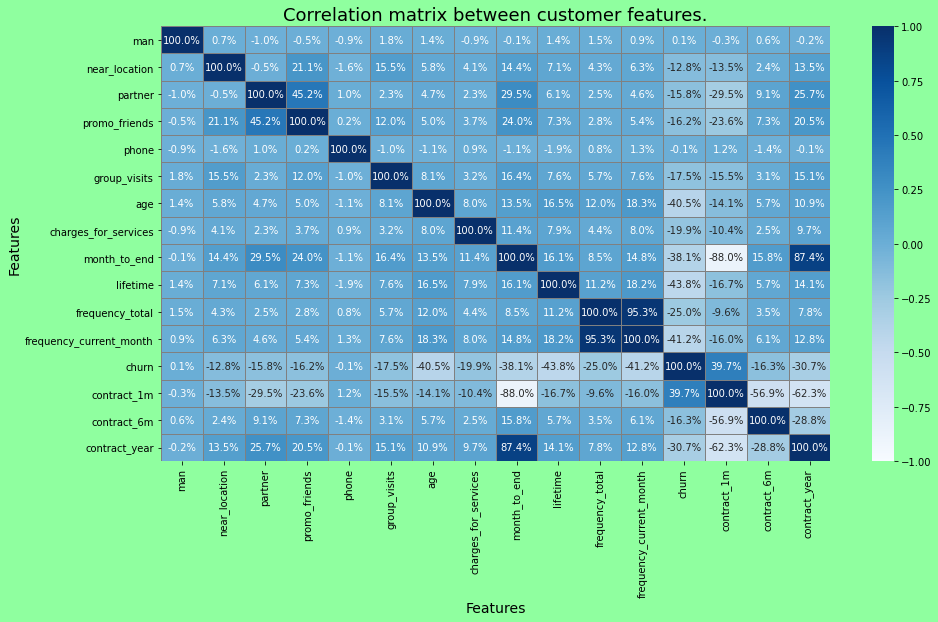

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor('xkcd:mint green')
plt.title('Correlation matrix between customer features.', fontsize=18)

sns.heatmap(gym_heatmap,
            annot= True,
            fmt = '.1%',
            linewidths = 1,
            linecolor = 'grey',
            vmin = -1,
            vmax = 1,
            cmap = 'Blues',
            yticklabels = True,
           )
ax.set_ylabel('Features', fontsize=14)
ax.set_xlabel('Features', fontsize=14)

As we can see, only three pairs of features have a strong correlation.
- 'Month_to_end_contract' and 'contract_year'
- 'Month_to_end_contract' and 'contract_1m'
- 'frequency_total' and 'frequency_current_month'
<br /><br />
Since we plan to use the **"Logistic regression"** model to predict customer churn, we need to remove one of the features in each pair. There is no need to remove highly correlated features for the "Random forest" algorithm. (I conducted an experiment and the **"Random forest"** algorithm on full data gives a better forecasting result)

In [ ]:
gym_lr = gym.drop(['month_to_end','frequency_total'],axis = 1)

Text(0.5, 0, 'Average frequency of visits per week over the preceding month')

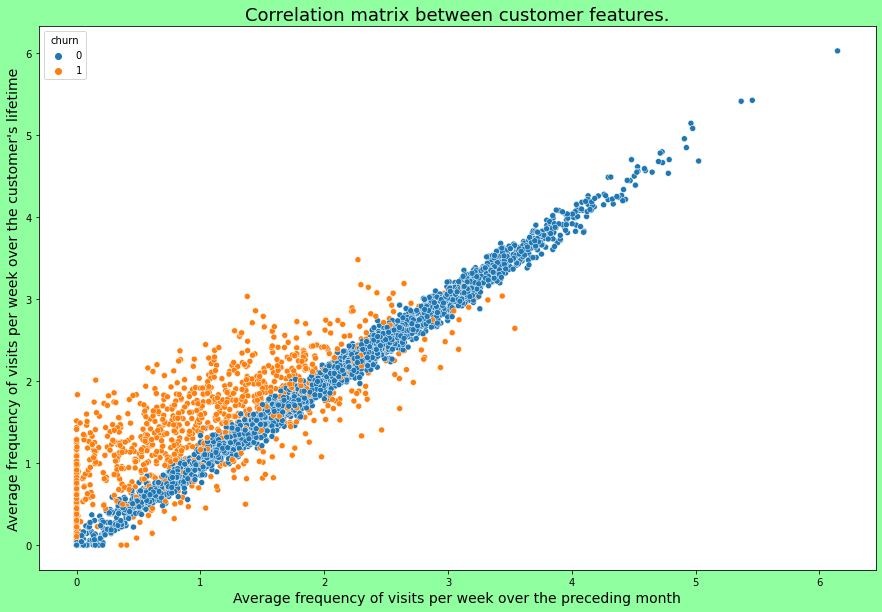

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('xkcd:mint green')
plt.title('Correlation matrix between customer features.', fontsize=18)

sns.scatterplot(data=gym,
                x='frequency_current_month',y='frequency_total',
                hue = 'churn'
)
ax.set_ylabel("Average frequency of visits per week over the customer's lifetime", fontsize=14)
ax.set_xlabel('Average frequency of visits per week over the preceding month', fontsize=14)

Conclusion: <br />
As we can see, for clients who continue to visit the gym, the frequency of visits does not change, however, for those who left, the frequency of visits has decreased in the last month, compared to the previous period.

### Step 3. Build a model to predict user churn<a name="model_predict"></a>

#### 3.1 Let's divide the data into train and validation sets.<a name="divide"></a>

In [ ]:
X = gym.drop('churn', axis = 1)
y = gym['churn']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
## for model Logistic Regression
X_lr = gym_lr.drop('churn', axis = 1)
y_lr = gym_lr['churn']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr,y_lr, test_size=0.2, random_state=0)

Since we do not plan to train models like "Linear regression" or models that are sensitive to distance, standardization and normalization of the data is not required yet.


#### 3.2 Let's train the model on the train set with "Logistic regression" method.<a name="lr"></a>

In [ ]:
# define the model's algorithm
lr_model = LogisticRegression(solver = 'lbfgs')
 # train our model
lr_model.fit(X_train_lr, y_train_lr)
# use the trained model to make forecasts
lr_predictions = lr_model.predict(X_test_lr)

#### 3.3 Let's train the model on the train set with "Random forest" method.<a name="rf"></a>

In [ ]:
# define the model's algorithm
rf_model = RandomForestClassifier(n_estimators = 500,
                                  max_features = 9,
                                  random_state = 0)
# train the random forest model
rf_model.fit(X_train, y_train)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
roc_value = roc_auc_score(y_test, rf_probabilities)
print("Roc_auc is {:.1%}".format(roc_value))

Roc_auc is 97.4%


In [ ]:
# define the function that will output our metrics
def calculate_metrics(y_true, y_pred):
    result = []
    result.append(accuracy_score(y_true, y_pred))
    result.append(precision_score(y_true, y_pred))
    result.append(recall_score(y_true, y_pred))
    return result


In [ ]:
lr_result = calculate_metrics(y_test_lr,lr_predictions)
rf_result = calculate_metrics(y_test,rf_predictions)

In [ ]:
#let's built graph
xasix_list = ['Accuracy','Precision','Recall']

fig = go.Figure()
plot_bar(fig, xasix_list, lr_result, "Logistic regression", 'green')
plot_bar(fig, xasix_list, rf_result, "Random forest", 'yellow')

update_layout(fig, 'Comparison of models', '')
fig.show()

Conclusion: <br /><br />
The "Random forest" model shows the best result for all metrics. We have unbalanced data, so the Accuracy metric won't work well. For our business problem, the Recall metric is more relevant, because we need to minimize the number of falsely negative cases when the model is mistaken and informs us that the client does not plan to stop training. Thus, we need to choose the Random forest model.
    

We have decided on a model that predicts the likelihood of customer churn depending on the features of a given customer. Now let's devide our clients into clusters.

### Step 4. Create user clusters<a name="clusters"></a>

#### 4.1 Standardize the data and plot a dendrogram<a name="dendrogram"></a>

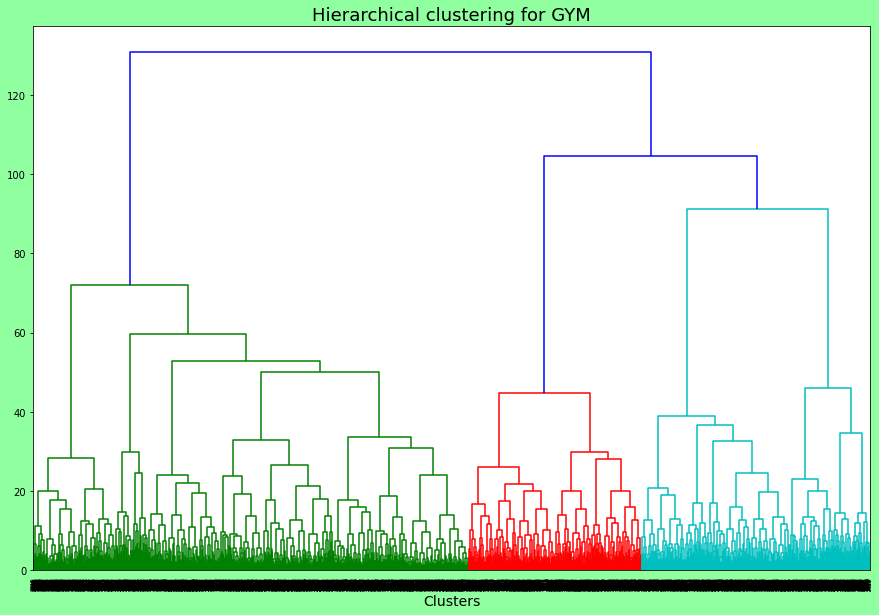

In [ ]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
linked = linkage(X_sc, method = 'ward')
# Build dendrogram
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('xkcd:mint green')
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM', fontsize=18)
ax.set_xlabel('Clusters', fontsize=14)
plt.show()

Conclusion:<br /><br />
As we can see from the dendrogram, the system offers us to divide clients into 3 clusters. However, according to the terms of reference during training, the model based on the K-Means algorithm will be divided into 5 clusters.

#### 4.2 Let's train the model on the train set with "K-means" algorithm.<a name="k_means"></a>

In [ ]:
# define the k_means model with 5 clusters
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)
# store cluster labels into the field of our dataset
gym['cluster'] = labels

##### Let's check how well the algorithm managed to divide clients into clusters.

In [ ]:
print('Silhouette score is {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette score is 0.16


The assessment of the quality of dividing clients into clusters is not high, which means that clients from one cluster are to some extent similar to clients from other clusters.

#### 4.3 The mean feature values for clusters.<a name="mean"></a>

In [ ]:
gym.groupby(['cluster']).mean().reset_index().T

,0,1,2,3,4
cluster,0.00,1.00,2.00,3.00,4.00
man,0.51,0.55,0.52,0.51,0.48
near_location,0.00,0.99,0.86,0.93,1.00
partner,0.43,0.33,0.58,0.72,0.34
promo_friends,0.07,0.27,0.37,0.48,0.22
phone,0.91,0.91,0.90,0.90,0.91
group_visits,0.19,0.47,0.44,0.54,0.32
age,28.36,30.12,29.55,29.82,27.95
charges_for_services,130.68,158.67,151.65,163.59,125.71
month_to_end,1.00,1.00,5.62,10.84,1.00


Dividing clients into 5 clusters using the K-means algorithm, we can draw the following conclusions:<br /><br />
- Clients who got into clusters 1, 2, and 3 are loyal and the probability that they will left is minimal, especially for clients who got into cluster 3.
- Clients who got into clusters 0 and 4 with a probability of more than 50% will stop attending the gym.
- Clients who live close to fall into cluster 0.
- Cluster 0 does not include clients who came from friends through promotions.
- Clients from clusters 0 and 4 like group lessons least of all.
- Average age and gender are distributed almost equally among all clusters.
- Clients who have a contract for more than 1 month fall into groups 2 and 3.
- Clients who have recently (on average 2.5 months) started attending the gym are distributed between clusters 0 and 4.
- Clients from Cluster 2 bought a 6-month contract.
- Clients from Cluster 3 bought a one-year contract.
- Clients who frequently go to the gym are in cluster 1, those who are rarely to go to the gym are in cluster 4

#### 4.4 Plot distributions of features for the clusters.<a name="distributions"></a>

In [ ]:
category_data_list = ['man',
                      'near_location',
                      'partner',
                      'promo_friends',
                      'phone',
                      'group_visits',
                      'contract_1m',
                      'contract_6m',
                      'contract_year']
numeric_data_list = ['age',
                     'charges_for_services',
                     'month_to_end',
                     'lifetime',
                     'frequency_current_month',
                     ]

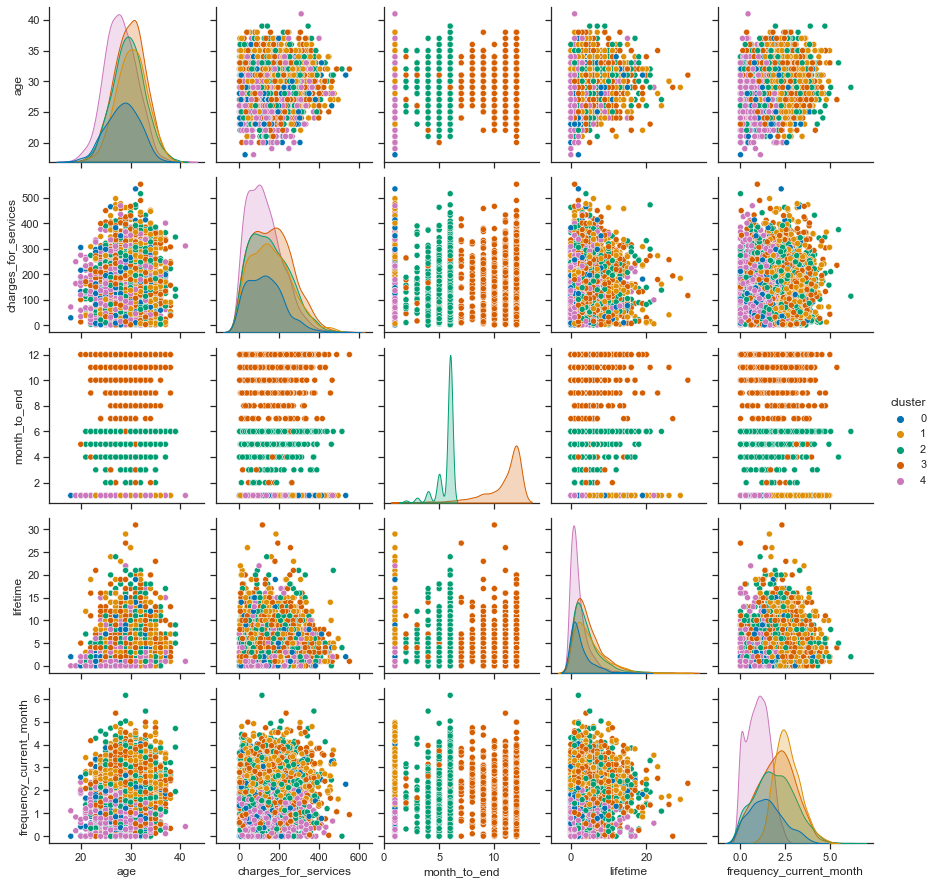

In [ ]:
warnings.simplefilter("ignore", UserWarning)

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(gym, hue = 'cluster', palette = "colorblind",
                 vars =numeric_data_list)
plt.show()

In [ ]:
def plot_subgraph(column, row, col):
    ax = sns.countplot(x = gym[column],
                       palette=color_dict, hue='cluster',
                       data=gym,
                       ax=axes[row, col])
    ax.set_title(column)
    if col != 0:
        ax.set(xlabel='',ylabel='')
    else:
        ax.set(xlabel='')
    ax.legend([],[], frameon=False)
    if row + col == 0:
        ax.legend(['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'],
                  bbox_to_anchor=(0., 1.2, 3.5, .102), ncol=5, mode="expand", borderaxespad=4.)
    ax.set_xticklabels(['False','True'])


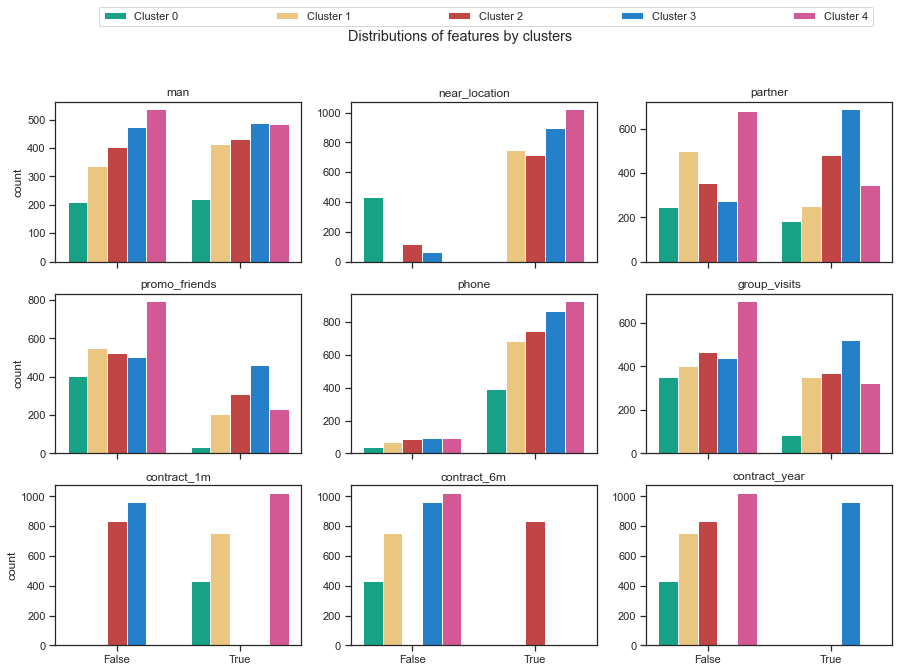

In [ ]:
# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
f.suptitle('Distributions of features by clusters')

for idx, column in enumerate(category_data_list):
    row, col = divmod(idx, 3)
    plot_subgraph(column,row, col)

As we can see, in the main, the clusters overlap strongly. <br />
The following features have an explicit division into clusters:<br />
- month_to_end
- contract_6m
- contract_year



#### 4.5 Calculate the churn rate for each cluster<a name="calculate"></a>

### Step 5.  Conclusions and basic recommendations<a name="conclusions"></a>

#### 5.1 Overall conclusion.<a name="overall_conclusion"></a>

#### 5.2 Recommendations.<a name="recommendations"></a>